### Hura_Model_Notebook

This notebook demonstrates the process of building, training, and evaluating a machine learning model for the Hura project. The model will handle translation and question-answering tasks for tourists in Kigali, Rwanda. It includes steps for data exploration, model architecture setup, training, and evaluation.


In [1]:
# Install required libraries
!pip install datasets transformers sentencepiece sacrebleu evaluate torch torchvision

# Install additional dependencies for Hugging Face transformers and tokenization
!pip install --quiet torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Check if everything is installed and working fine
import torch
import transformers
print("PyTorch version:", torch.__version__)
print("Transformers version:", transformers.__version__)

PyTorch version: 2.6.0+cu124
Transformers version: 4.52.4


## **1. Data Exploration and Visualization**



### 1.1 Data Loading

First, we load and inspect the dataset used to train the model. This includes the translation dataset for the Kinyarwanda–English task and the combined question-answering (QA) dataset.

In [4]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict

# Define your data directory path
data_dir = "/content/drive/MyDrive/datasets/translation"

# Function to load TSV files into Hugging Face Dataset
def load_tsv_to_dataset(file_path):
    print(f"Loading {file_path} ...")
    df = pd.read_csv(file_path, delimiter='\t', encoding='ISO-8859-1', header=None, names=["kin", "en"])
    print(f"Loaded dataframe shape: {df.shape}")
    return Dataset.from_pandas(df)

# Load the datasets
train_ds = load_tsv_to_dataset(os.path.join(data_dir, "kinyarwanda-english-corpus.tsv"))
val_ds = load_tsv_to_dataset(os.path.join(data_dir, "kinyarwanda-english-corpus2.tsv"))
test_ds = load_tsv_to_dataset(os.path.join(data_dir, "kinyarwanda-english-corpus3.tsv"))

# Create DatasetDict to organize the splits
translation_dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

# Display dataset info
print("\nLoaded Translation Dataset Summary:")
print(translation_dataset)


Loading /content/drive/MyDrive/datasets/translation/kinyarwanda-english-corpus.tsv ...
Loaded dataframe shape: (14411, 2)
Loading /content/drive/MyDrive/datasets/translation/kinyarwanda-english-corpus2.tsv ...
Loaded dataframe shape: (25015, 2)
Loading /content/drive/MyDrive/datasets/translation/kinyarwanda-english-corpus3.tsv ...
Loaded dataframe shape: (8398, 2)

Loaded Translation Dataset Summary:
DatasetDict({
    train: Dataset({
        features: ['kin', 'en'],
        num_rows: 14411
    })
    validation: Dataset({
        features: ['kin', 'en'],
        num_rows: 25015
    })
    test: Dataset({
        features: ['kin', 'en'],
        num_rows: 8398
    })
})


In [5]:
import json

# Function to load JSON files
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# Load QA datasets
qa_tripadvisor = load_json('/content/drive/MyDrive/datasets/qa/tripadvisor_forum.json')
qa_faq = load_json('/content/drive/MyDrive/datasets/qa/tourism_faq_gov.json')
qa_blog = load_json('/content/drive/MyDrive/datasets/qa/local_blog_etiquette.json')

# Print the number of QA pairs in each dataset
print(f"TripAdvisor QA pairs: {len(qa_tripadvisor)}")
print(f"Tourism FAQ pairs: {len(qa_faq)}")
print(f"Local Blog etiquette pairs: {len(qa_blog)}")

TripAdvisor QA pairs: 81
Tourism FAQ pairs: 22
Local Blog etiquette pairs: 49


In [6]:
# Combine all QA datasets
combined_qa = qa_tripadvisor + qa_faq + qa_blog
print(f"Total combined QA pairs: {len(combined_qa)}")

# Convert combined QA into a Hugging Face Dataset
from datasets import Dataset
combined_qa_dataset = Dataset.from_list(combined_qa)
print(combined_qa_dataset)

Total combined QA pairs: 152
Dataset({
    features: ['question', 'answer'],
    num_rows: 152
})


### 1.2 Data Exploration - Visualizing Sentence Lengths

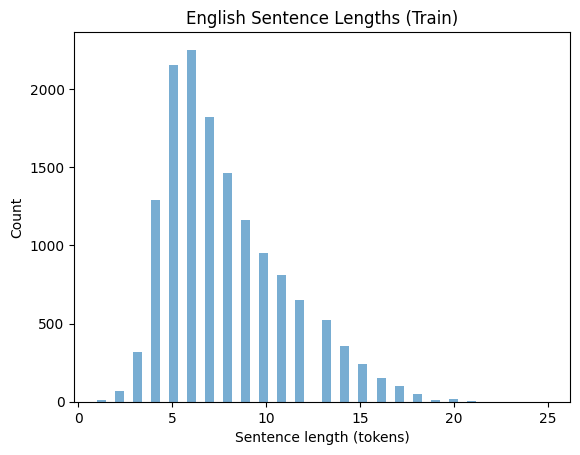

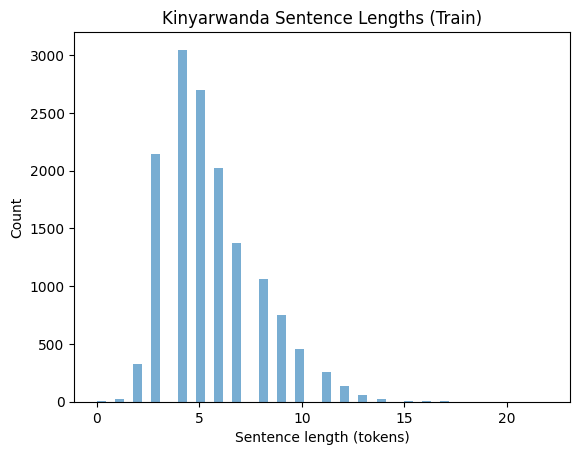

In [7]:
import matplotlib.pyplot as plt

# Function to plot sentence lengths for both source and target languages
def plot_sentence_lengths(dataset, lang_col, title):
    lengths = [len(str(s).split()) for s in dataset[lang_col]]
    plt.hist(lengths, bins=50, alpha=0.6)
    plt.title(title)
    plt.xlabel("Sentence length (tokens)")
    plt.ylabel("Count")
    plt.show()

# Plot sentence lengths for the training set in both languages
plot_sentence_lengths(translation_dataset['train'], 'en', 'English Sentence Lengths (Train)')
plot_sentence_lengths(translation_dataset['train'], 'kin', 'Kinyarwanda Sentence Lengths (Train)')


Explanation:

- The visualizations above show the sentence length distribution for the training data in both English and Kinyarwanda.

- It’s useful to identify whether the dataset contains excessively short or long sentences that might need filtering.

## **2. Data Cleaning & Preprocessing**

### 2.1 Text Cleaning Function

In [8]:
# Function to clean text (lowercase and remove leading/trailing spaces)
def clean_text(text):
    if text is None:
        return ""
    return str(text).strip().lower()

In [9]:
# Preprocess translation examples (for both languages)
def preprocess_translation_examples(example):
    example["en"] = clean_text(example["en"])
    example["kin"] = clean_text(example["kin"])
    return example

# Apply the preprocessing function to the translation dataset
translation_dataset = translation_dataset.map(preprocess_translation_examples)

Map:   0%|          | 0/14411 [00:00<?, ? examples/s]

Map:   0%|          | 0/25015 [00:00<?, ? examples/s]

Map:   0%|          | 0/8398 [00:00<?, ? examples/s]

In [10]:
# Preprocess QA examples (clean question and answer text)
def preprocess_qa_examples(example):
    example["question"] = clean_text(example.get("question", ""))
    example["answer"] = clean_text(example.get("answer", ""))
    return example

# Apply the preprocessing function to the QA dataset
combined_qa_dataset = combined_qa_dataset.map(preprocess_qa_examples)

Map:   0%|          | 0/152 [00:00<?, ? examples/s]

## **3. Model Architecture Setup, Tokenization & Training for Translation**

### 3.1 Tokenize for Translation

In [11]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# Load pre-trained mBART model for translation (Kinyarwanda ↔ English)
model_name = 'facebook/mbart-large-50-many-to-many-mmt'  # This model supports many languages including Kinyarwanda and English
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Define the source and target language codes
source_lang = "kin_XX"  # Kinyarwanda to English
target_lang = "en_XX"   # English to Kinyarwanda

# --- IMPORTANT: Set the source and target languages on the tokenizer instance ---
tokenizer.src_lang = source_lang
tokenizer.tgt_lang = target_lang

# Function to tokenize the translation examples
def preprocess_translation_for_model(example):
    # Tokenize the source (Kinyarwanda) and target (English) sentences
    # The tokenizer now knows the src_lang and tgt_lang from the attributes set above
    # No need to pass src_lang/tgt_lang here when using batched=True
    inputs = tokenizer(example['kin'], truncation=True, padding='max_length', max_length=128, return_tensors="pt")
    targets = tokenizer(example['en'], truncation=True, padding='max_length', max_length=128, return_tensors="pt")

    # Add the target as labels for the training process
    inputs['labels'] = targets['input_ids']
    return inputs

# Tokenize the translation dataset
# Ensure batched=True is used as before
translation_dataset = translation_dataset.map(preprocess_translation_for_model, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

Map:   0%|          | 0/14411 [00:00<?, ? examples/s]

Map:   0%|          | 0/25015 [00:00<?, ? examples/s]

Map:   0%|          | 0/8398 [00:00<?, ? examples/s]

Explanation:

- The text cleaning process helps standardize the data by removing unnecessary characters, ensuring consistency in the model’s input.

In [12]:
# --- Add inspection of the tokenized dataset ---
print("\nInspecting tokenized translation_dataset['train']:")
print(translation_dataset['train'])
print("\nFirst example in train dataset:", translation_dataset['train'][0])

print("\nInspecting tokenized translation_dataset['validation']:")
print(translation_dataset['validation'])
print("\nFirst example in validation dataset:", translation_dataset['validation'][0])
# --- End of inspection ---


Inspecting tokenized translation_dataset['train']:
Dataset({
    features: ['kin', 'en', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 14411
})

First example in train dataset: {'kin': 'uruvunge rw\x92abatuye uwo mujyi', 'en': 'the crowd of the people who live in that city', 'input_ids': [3, 75, 149696, 44687, 1690, 434, 17335, 11, 99878, 1033, 4424, 31, 135558, 2387, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 3.2 Training

In [ ]:
from transformers import Trainer, TrainingArguments

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",  # output directory for model checkpoints
    eval_strategy="epoch",  # Evaluate after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",  # directory for storing logs
    save_strategy="epoch",  # Save checkpoints after each epoch
    gradient_accumulation_steps=4,
    load_best_model_at_end=True,
)

# Define the trainer
trainer = Trainer(
    model=model,  # The model you want to fine-tune
    args=training_args,
    train_dataset=translation_dataset['train'],  # Training dataset
    eval_dataset=translation_dataset['validation'],  # Validation dataset
    tokenizer=tokenizer  # The tokenizer for your model
)

# Start training
trainer.train()


<ipython-input-22-1d2dcdeb2c18>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.137500,0.151562
2,0.085000,0.134244
3,0.057900,0.134855


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=2703, training_loss=0.27699852236720574, metrics={'train_runtime': 10865.5367, 'train_samples_per_second': 3.979, 'train_steps_per_second': 0.249, 'total_flos': 1.1711440157147136e+16, 'train_loss': 0.27699852236720574, 'epoch': 3.0})

### 3.3 Evaluation

In [ ]:
from datasets import load_metric

# Load SacreBLEU metric
bleu_metric = load_metric("sacrebleu")

# Function to compute BLEU score
def compute_bleu(predictions, references):
    # Decode predictions and references from token IDs
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(references, skip_special_tokens=True)

    # Compute BLEU score
    bleu_score = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return bleu_score

# Compute BLEU on the validation set
# trainer.compute_metrics = compute_bleu
eval_results = trainer.evaluate()

print("Evaluation results:", eval_results)


<ipython-input-23-4db3fa4c3afd>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


Evaluation results: {'eval_loss': 0.13424409925937653, 'eval_runtime': 1242.9027, 'eval_samples_per_second': 20.126, 'eval_steps_per_second': 5.032, 'epoch': 3.0}


In [ ]:
# Evaluate on the test set to see how well the model generalizes
test_results = trainer.evaluate(eval_dataset=translation_dataset["test"])
print("Test results:", test_results)


### 3.4 Testing

In [ ]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model to the appropriate device
model.to(device)

# Function to generate translation from a text input
def translate_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(inputs['input_ids'])
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test with some sample sentences
sample_text = "Aho Kigali Genocide Memorial iri?"
translated_text = translate_text(sample_text)
print(f"Translated text: {translated_text}")



Translated text: is there a kigali genocide memorial?


In [ ]:
# Test multiple Kinyarwanda sentences
kin_sentences = [
    "Aho Kigali Genocide Memorial iri?",   # Where is the Kigali Genocide Memorial?
    "Ni ibihe byiza byo gusura Kigali?",  # What are the best places to visit in Kigali?
    "Ntabwo ari byiza gukoresha telefoni mu muhanda.",      # It is not safe to use a phone while crossing the street.
    "Iki ni igishushanyo cya Kigali."                      # This is a map of Kigali.
]

for sentence in kin_sentences:
    translated = translate_text(sentence)
    print(f"Original Kinyarwanda: {sentence}")
    print(f"Translated English: {translated}")
    print("="*50)


Original Kinyarwanda: Aho Kigali Genocide Memorial iri?
Translated English: is there a kigali genocide memorial?
Original Kinyarwanda: Ni ibihe byiza byo gusura Kigali?
Translated English: what are the best times to visit kigali?
Original Kinyarwanda: Ntabwo ari byiza gukoresha telefoni mu muhanda.
Translated English: it's not good to use a mobile phone on the road.
Original Kinyarwanda: Iki ni igishushanyo cya Kigali.
Translated English: this is a picture of kigali.


In [ ]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("/content/drive/MyDrive/hura/hura_translation_model")
tokenizer.save_pretrained("/content/drive/MyDrive/hura/hura_translation_model")


('/content/drive/MyDrive/hura/hura_translation_model/tokenizer_config.json',
 '/content/drive/MyDrive/hura/hura_translation_model/special_tokens_map.json',
 '/content/drive/MyDrive/hura/hura_translation_model/sentencepiece.bpe.model',
 '/content/drive/MyDrive/hura/hura_translation_model/added_tokens.json',
 '/content/drive/MyDrive/hura/hura_translation_model/tokenizer.json')

## 4. Model Architecture Setup, Tokenization & Training for Q&A

### 4.1 Tokenize for QA

In [14]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load T5 tokenizer
model_name = 't5-small'  # Use a smaller model or change to 't5-base' for better performance
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Function to preprocess and tokenize QA examples for T5
def preprocess_qa_for_model(example):
    # Format for T5: "question: <question>"
    inputs = [f"question: {q}" for q in example['question']]
    targets = example['answer']

    # Tokenizing inputs and targets
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding=True)
    labels = tokenizer(targets, max_length=64, truncation=True, padding=True)

    # Adding labels as input_ids for training
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Apply preprocessing to the combined Q&A dataset
combined_qa_dataset = combined_qa_dataset.map(preprocess_qa_for_model, batched=True)

# Check a sample preprocessed example
print(combined_qa_dataset[0])  # Display the first tokenized example


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/152 [00:00<?, ? examples/s]

{'question': 'is taxis in kigali metered or do i need to negotiate?', 'answer': 'most taxis in kigali use meters. make sure you see the driver turn on the meter. if the meter isn’t working, negotiate a fair price before getting in.', 'input_ids': [822, 10, 19, 9256, 7, 16, 3, 2168, 6191, 23, 140, 11196, 42, 103, 3, 23, 174, 12, 17405, 58, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [167, 9256, 7, 16, 3, 2168, 6191, 23, 169, 8848, 5, 143, 417, 25, 217, 8, 2535, 919, 30, 8, 3, 4401, 5, 3, 99, 8, 3, 4401, 19, 29, 22, 17, 464, 6, 17405, 3, 9, 2725, 594, 274, 652, 16, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


### 4.2 Splitting QA Dataset into Train/Validation/Test

In [15]:
# --- Splitting the data ---
# Split combined QA dataset into train, validation, and test sets
qa_train_test = combined_qa_dataset.train_test_split(test_size=0.2, seed=42)
qa_val_test = qa_train_test["test"].train_test_split(test_size=0.5, seed=42)

# Create final DatasetDict for QA datasets
from datasets import DatasetDict

qa_datasets = DatasetDict({
    "train": qa_train_test["train"],
    "validation": qa_val_test["train"],  # 10% of the original dataset
    "test": qa_val_test["test"]         # 10% of the original dataset
})

# Print the split dataset summary
print(qa_datasets)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 121
    })
    validation: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 16
    })
})


### 4.3 Training

In [16]:
from transformers import Trainer, TrainingArguments

# Define the training arguments for the T5 model
training_args = TrainingArguments(
    output_dir="./qa_results",  # output directory for model checkpoints
    eval_strategy="epoch",  # Evaluate after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",  # directory for storing logs
    save_strategy="epoch",  # Save checkpoints after each epoch
    load_best_model_at_end=True,  # Load the best model when finished training
)

# Define the Trainer
trainer = Trainer(
    model=model,  # The model you want to fine-tune
    args=training_args,
    train_dataset=qa_datasets["train"],  # Training dataset
    eval_dataset=qa_datasets["validation"],  # Validation dataset
    tokenizer=tokenizer  # The tokenizer for your model
)

# Start training
trainer.train()


<ipython-input-16-ac64a1603cd4>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m-azeez (m-azeez-african-leadership-university-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,7.337288
2,No log,6.084282
3,No log,5.670404


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=48, training_loss=6.877877553304036, metrics={'train_runtime': 56.6503, 'train_samples_per_second': 6.408, 'train_steps_per_second': 0.847, 'total_flos': 4701805903872.0, 'train_loss': 6.877877553304036, 'epoch': 3.0})

### 4.4 Evaluation & Testing

In [17]:
# Evaluate on the validation set to check how well the model is performing
eval_results = trainer.evaluate(eval_dataset=qa_datasets["validation"])
print("Validation results:", eval_results)

# Evaluate on the test set to check performance on unseen data
test_results = trainer.evaluate(eval_dataset=qa_datasets["test"])
print("Test results:", test_results)


Validation results: {'eval_loss': 5.670403957366943, 'eval_runtime': 0.0741, 'eval_samples_per_second': 202.42, 'eval_steps_per_second': 26.989, 'epoch': 3.0}
Test results: {'eval_loss': 5.284791469573975, 'eval_runtime': 0.075, 'eval_samples_per_second': 213.336, 'eval_steps_per_second': 26.667, 'epoch': 3.0}


In [19]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model to the appropriate device
model.to(device)

# Function to generate answers from a question
def answer_question(question):
    # Tokenize the input question
    inputs = tokenizer(f"question: {question}", return_tensors="pt", truncation=True, padding=True).to(device)

    # Generate the answer from the model
    outputs = model.generate(inputs['input_ids'])

    # Decode and return the answer
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example question to test the model
example_question = "Where can I buy anti-malarial pills in Kigali?"
print("Answer:", answer_question(example_question))



Answer: You can get malaria at pharmacy


In [28]:
# Test with multiple questions
test_questions = [
    "What is a tourism entity?",
    "Who must register as a tour operator in Kigali?",
    "What services can I access on the Tourism Regulation platform?"
]

for question in test_questions:
    print(f"Question: {question}")
    print(f"Answer: {answer_question(question)}")
    print("="*50)


Question: How do I greet someone in Rwanda?
Answer: Say Muraho
Question: Who must register as a tour operator in Kigali?
Answer: Tourism License and official guide
Question: What are the best things to see and do in Kigali Area?
Answer: Visit Genocide Memorial and Ghaya Links golf course


In [29]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("/content/drive/MyDrive/hura/hura_qa_model")
tokenizer.save_pretrained("/content/drive/MyDrive/hura/hura_qa_model")


('/content/drive/MyDrive/hura/hura_qa_model/tokenizer_config.json',
 '/content/drive/MyDrive/hura/hura_qa_model/special_tokens_map.json',
 '/content/drive/MyDrive/hura/hura_qa_model/spiece.model',
 '/content/drive/MyDrive/hura/hura_qa_model/added_tokens.json')